# Importing needed Libraries

In [76]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
import spacy
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,LancasterStemmer,WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.cluster import KMeans

In [46]:
from warnings import filterwarnings
filterwarnings("ignore")

# Overview

In [2]:
data = load_files('bbc/',encoding='utf-8',decode_error='replace')

In [3]:
data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [4]:
cls = data["target_names"]

In [5]:
df = pd.DataFrame({"data":data["data"],"target":data["target"]})

In [6]:
df.head()

,data,target
0,Tate & Lyle boss bags top award\n\nTate & Lyle...,0
1,Halo 2 sells five million copies\n\nMicrosoft ...,4
2,MSPs hear renewed climate warning\n\nClimate c...,2
3,Pavey focuses on indoor success\n\nJo Pavey wi...,3
4,Tories reject rethink on axed MP\n\nSacked MP ...,2


In [7]:
mapper = {i:k for i,k in enumerate(cls)}
mapper

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

In [8]:
df.dtypes

data      object
target     int32
dtype: object

In [9]:
df.sample(5)

,data,target
866,Ref stands by Scotland decisions\n\nThe refere...,3
639,Veteran Martinez wins Thai title\n\nConchita M...,3
280,Collins named UK Athletics chief\n\nUK Athleti...,3
657,Court halts Mark Morrison album\n\nPremiership...,1
2184,Reyes tricked into Real admission\n\nJose Anto...,3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    2225 non-null   object
 1   target  2225 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 26.2+ KB


In [11]:
df.describe()

,target
count,2225.000000
mean,1.958202
std,1.428310
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [12]:
df.index

RangeIndex(start=0, stop=2225, step=1)

In [13]:
df.columns

Index(['data', 'target'], dtype='object')

# data Processing

In [14]:
df.isna().sum()

data      0
target    0
dtype: int64

In [15]:
df[df.duplicated(subset='data')]

,data,target
100,Spain coach faces racism inquiry\n\nSpain's Fo...,3
229,US duo in first spam conviction\n\nA brother a...,4
284,Jobs growth still slow in the US\n\nThe US cre...,0
302,Brown ally rejects Budget spree\n\nChancellor ...,2
339,Musical treatment for Capra film\n\nThe classi...,1
...,...,...
2171,T-Mobile bets on 'pocket office'\n\nT-Mobile h...,4
2182,S Korea spending boost to economy\n\nSouth Kor...,0
2190,US blogger fired by her airline\n\nA US airlin...,4
2212,Apple unveils low-cost 'Mac mini'\n\nApple has...,4


In [16]:
df.drop_duplicates(keep='first',inplace=True,ignore_index=True)

In [17]:
df[df.duplicated()]

,data,target


In [18]:
df.target.value_counts()

target
3    505
0    503
2    403
1    369
4    347
Name: count, dtype: int64

In [19]:
a = df.loc[0,"data"]
a

'Tate & Lyle boss bags top award\n\nTate & Lyle\'s chief executive has been named European Businessman of the Year by a leading business magazine.\n\nIain Ferguson was awarded the title by US publication Forbes for returning one of the UK\'s "venerable" manufacturers to the country\'s top 100 companies. The sugar group had been absent from the FTSE 100 for seven years until Mr Ferguson helped it return to growth. Tate\'s shares have leapt 55% this year, boosted by firming sugar prices and sales of its artificial sweeteners.\n\n"After years of a sagging stock price and a seven-year hiatus from the FTSE 100, one of Britain\'s venerable manufacturers has returned to the vaunted index," Forbes said. Mr Ferguson took the helm at the company in 2003, after spending most of his career at consumer goods giant Unilever. Tate & Lyle, which was an original member of the historic FT-30 index in 1935, operates more than 41 factories and 20 more additional production facilities in 28 countries. Prev

In [20]:
nlp = spacy.load("en_core_web_lg")
nlp.Defaults.stop_words.add("not")
nlp.vocab["not"].is_stop = False

In [21]:
def process(txt):
    l = []
    txt = re.sub(r"[\"\']"," ",txt)
    txt = re.sub("[\n\t]"," ",txt)
    txt = re.sub("\s+[\w]\s+"," ",txt)
    txt = re.sub("[^A-Za-z]"," ",txt)
    txt = re.sub("\s+"," ",txt)
    txt = txt.strip()
    txt = txt.lower()    # trying to catch any Word with capital letters to prevent making vectors of capital and small letters words 
    doc = nlp(txt)
    for token in doc:
        if not (token.is_stop or token.is_punct or token.is_space):
            l.append(token.lemma_)
    return " ".join(l)

In [22]:
process(a)

'tate lyle boss bag award tate lyle chief executive name european businessman year lead business magazine iain ferguson award title publication forbes return uk venerable manufacturer country company sugar group absent ftse seven year mr ferguson help return growth tate share leap year boost firm sugar price sale artificial sweetener year sag stock price seven year hiatus ftse britain venerable manufacturers return vaunted index forbes say mr ferguson take helm company spend career consumer good giant unilever tate lyle original member historic ft index operate factory additional production facility country previous winner forbes award include royal bank scotland chief executive fred goodwin vodafone boss chris gent'

In [23]:
df["data"] = df["data"].apply(process)

In [24]:
df["class"] = df["target"].map(mapper)

In [25]:
df.head(2)

,data,target,class
0,tate lyle boss bag award tate lyle chief execu...,0,business
1,halo sell million copy microsoft celebrate bum...,4,tech


# Data Visualization

In [27]:
x = df["class"].value_counts().values
l = df["class"].value_counts().index

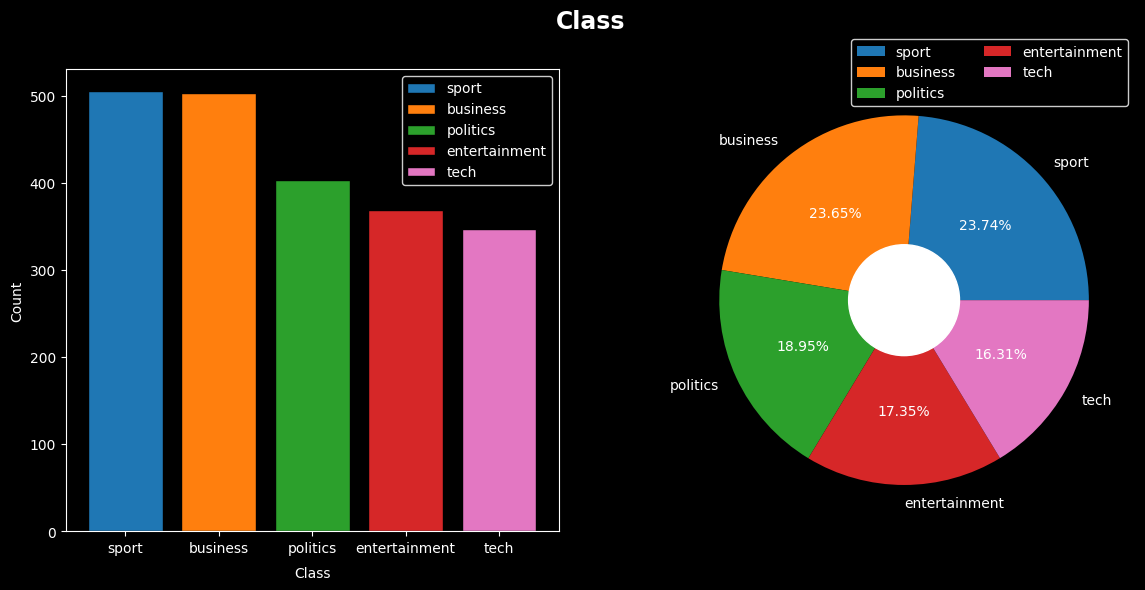

In [28]:
with plt.style.context("dark_background"):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#e377c2']
    plt.figure(figsize=(14,6))
    plt.suptitle("Class",fontsize=17,weight='bold')
    plt.subplot(1,2,1)
    plt.bar(l,x,label=l,edgecolor="black",color=colors)
    plt.xlabel("Class",labelpad=8)
    plt.ylabel("Count")
    plt.legend(shadow=True)
    plt.subplot(1,2,2)
    plt.pie(x,labels=l,autopct='%.2f%%',colors=colors)
    circle = plt.Circle((0, 0), 0.3, color='white')
    plt.gca().add_artist(circle)
    plt.legend(shadow=True,ncols=2,bbox_to_anchor=(1,1.08))
    plt.show()

In [29]:
df["length"] = df["data"].apply(lambda x: len(x))

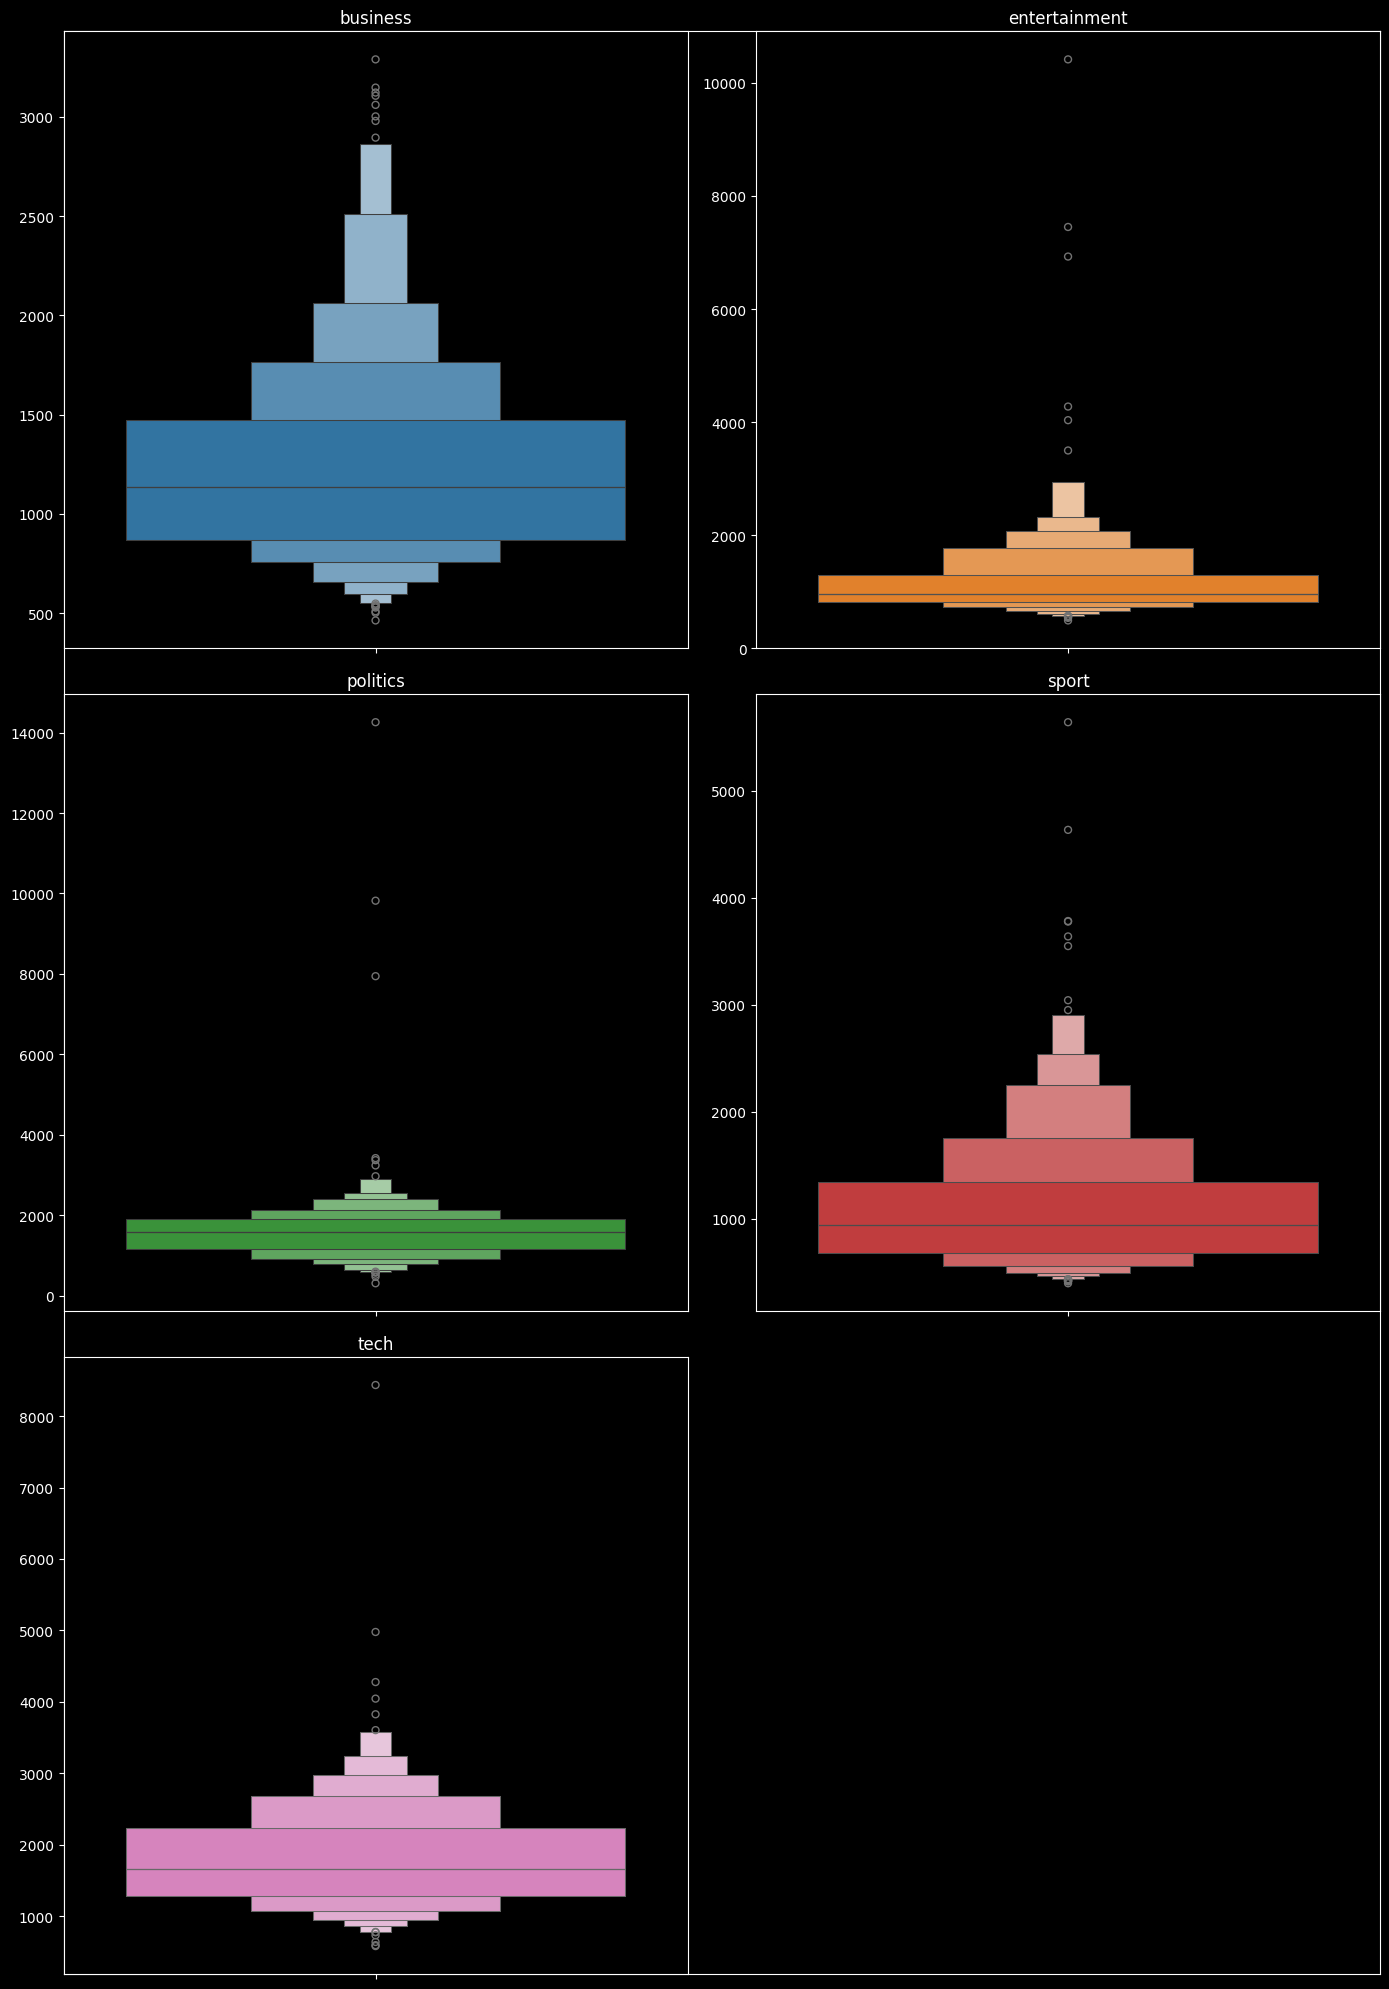

In [30]:
with plt.style.context("dark_background"):
    plt.figure(figsize=(14,20))
    plt.yticks([])
    plt.xticks([])
    for i in range(len(cls)):
        plt.subplot(3,2,i+1,)
        plt.title(cls[i])
        sns.boxenplot(y=df.groupby("class")["length"].get_group(cls[i]).values,color=colors[i])
    plt.tight_layout()
    plt.show()

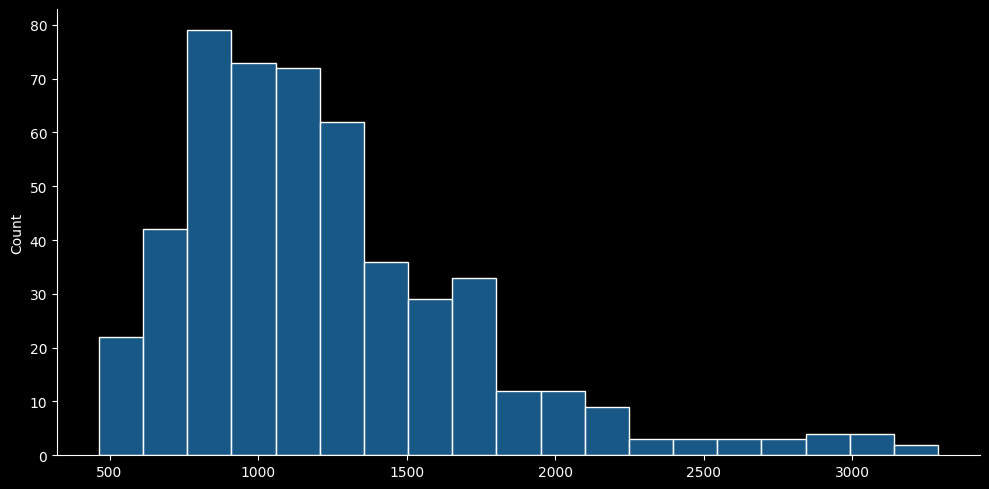

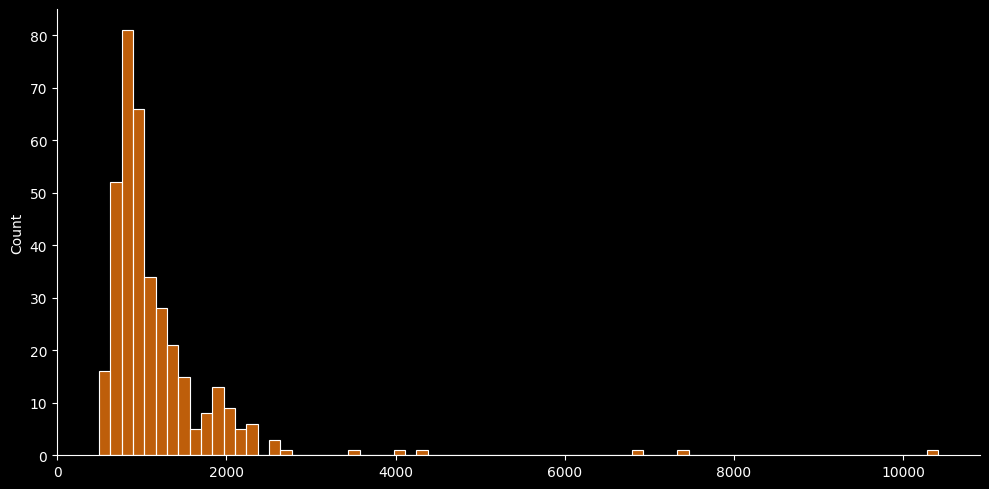

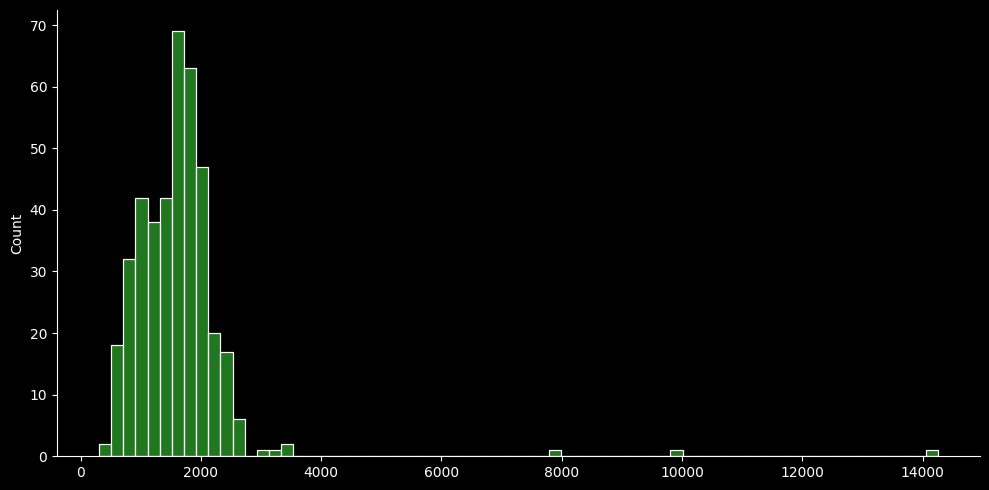

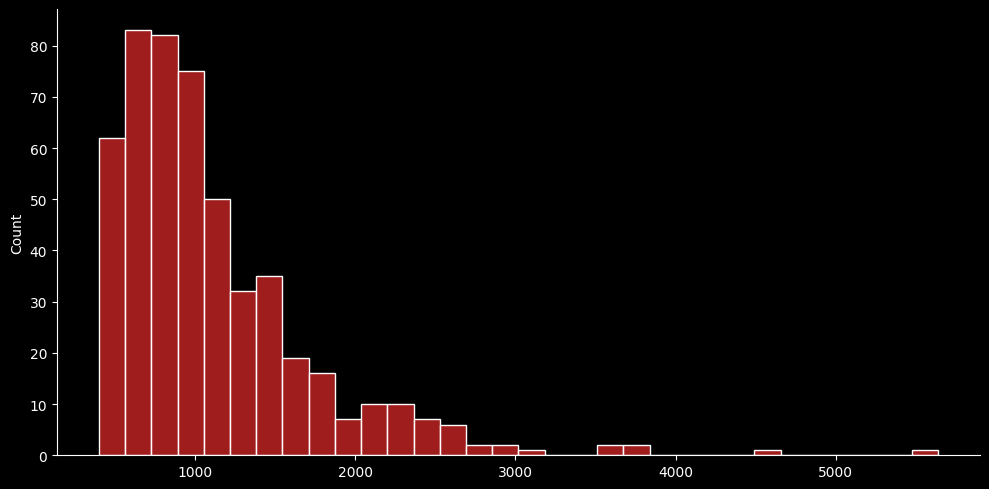

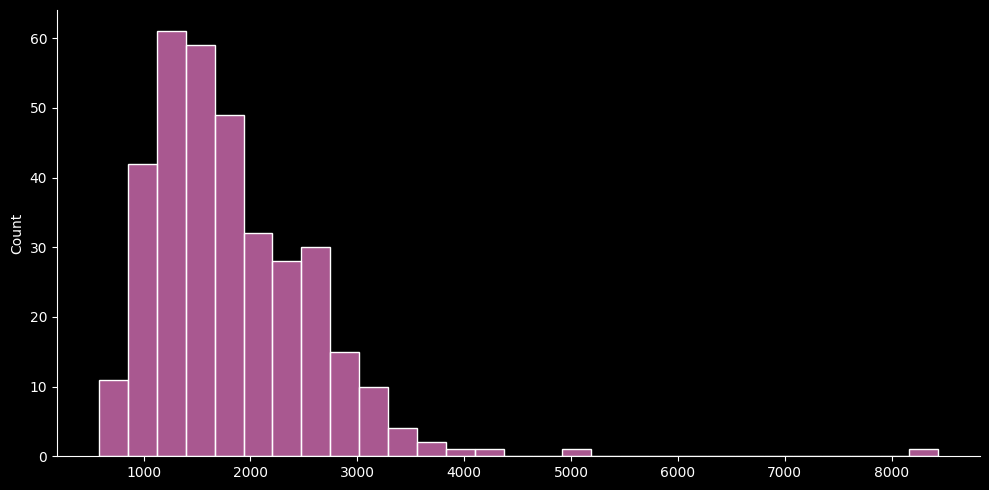

In [35]:
with plt.style.context("dark_background"):
    for i in range(len(cls)):
        sns.displot(x=df.groupby("class")["length"].get_group(cls[i]).values,color=colors[i],aspect=2)
    plt.tight_layout()
    plt.show()

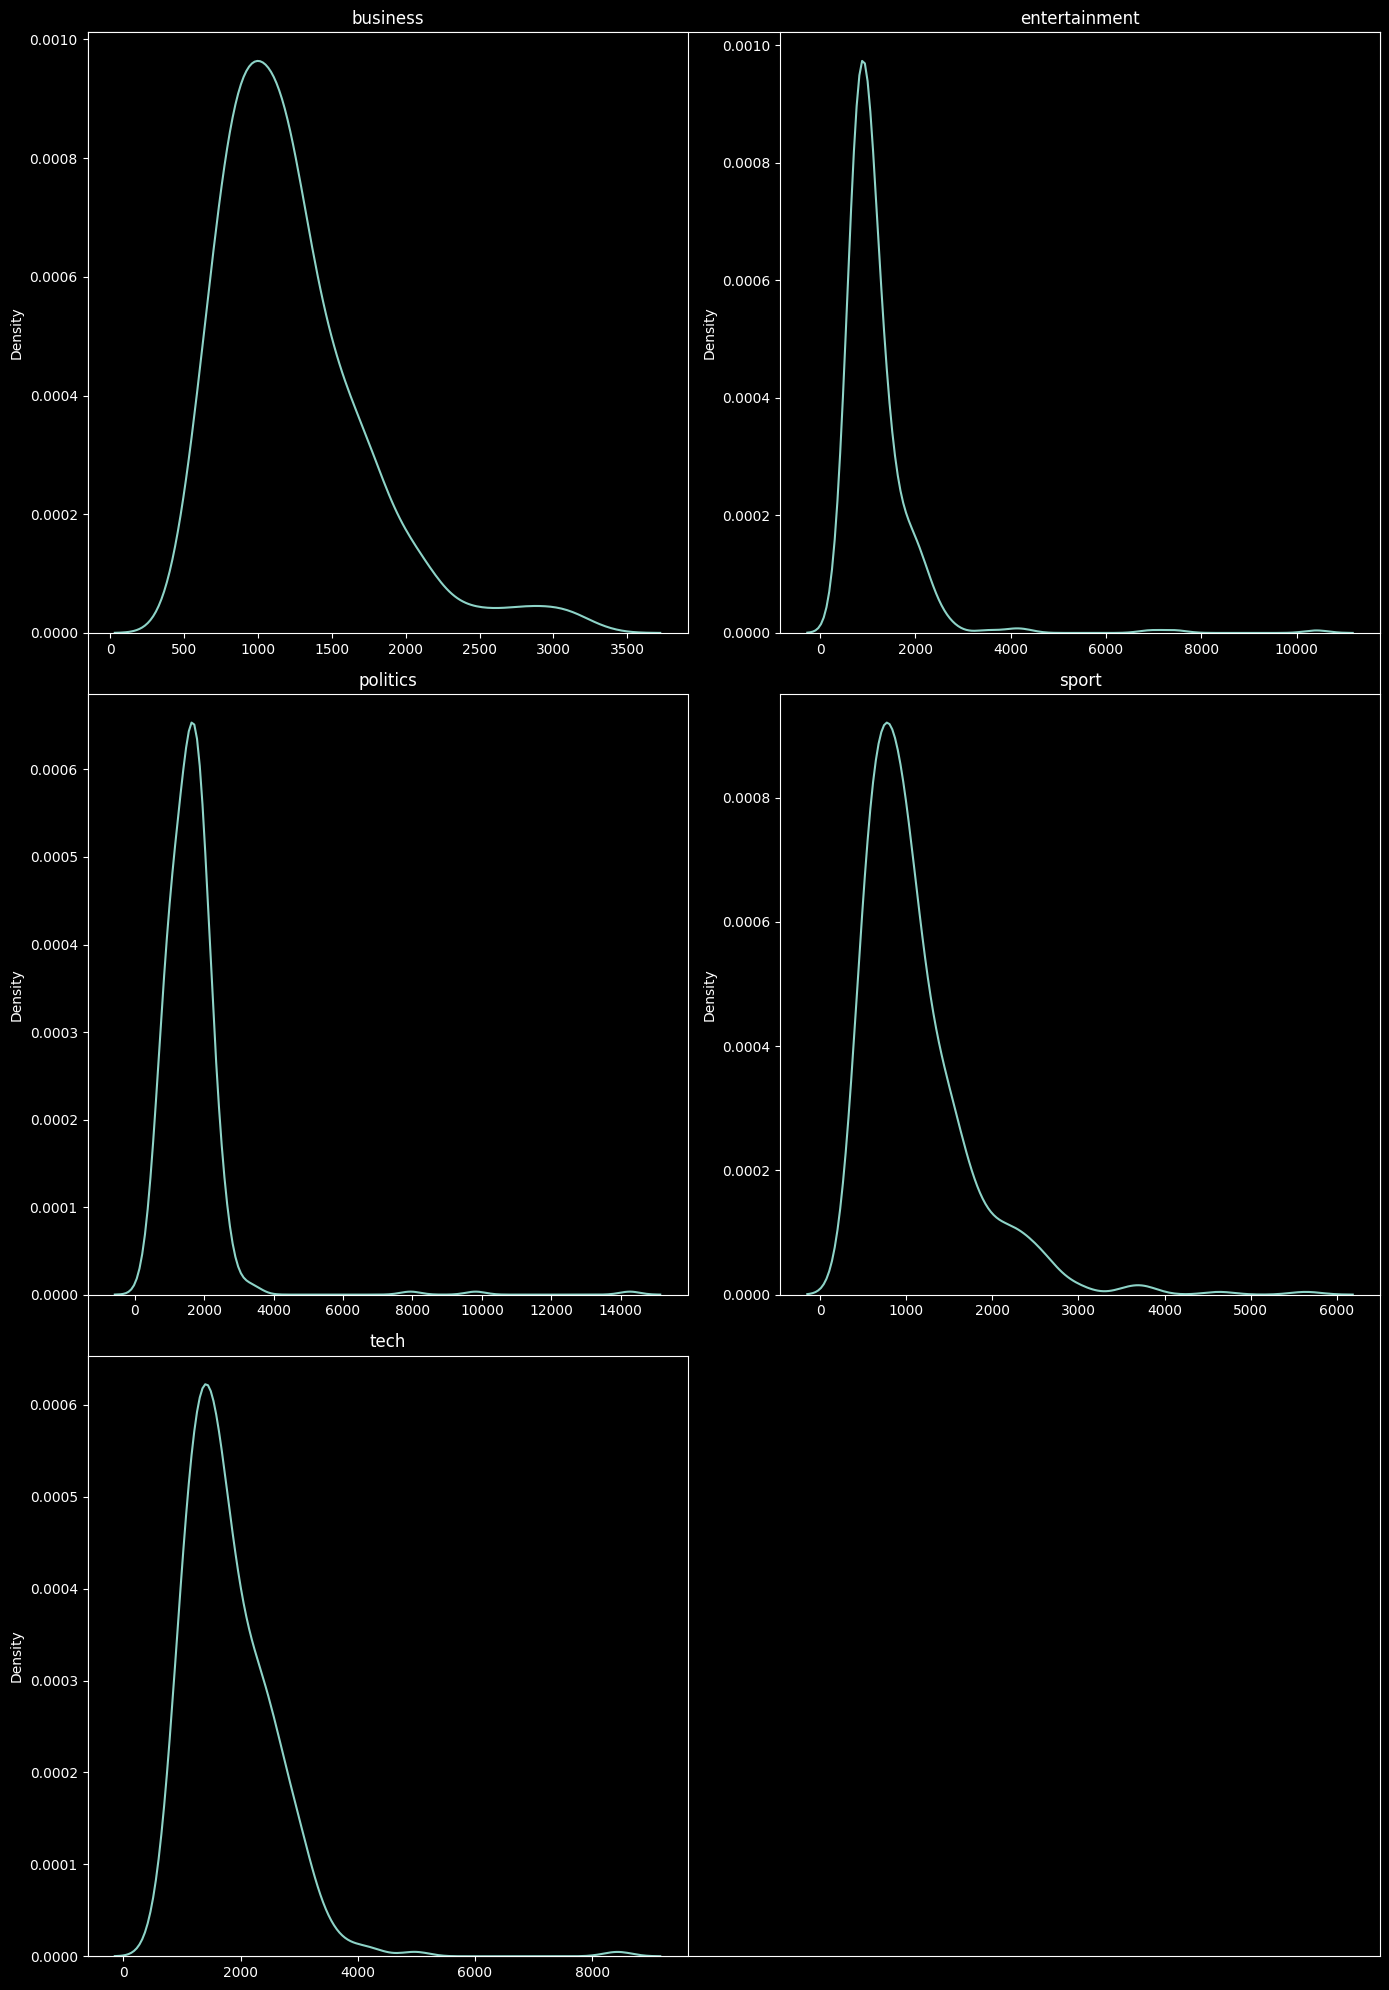

In [40]:
with plt.style.context("dark_background"):
    plt.figure(figsize=(14,20))
    plt.yticks([])
    plt.xticks([])
    for i in range(len(cls)):
        plt.subplot(3,2,i+1,)
        plt.title(cls[i])
        sns.kdeplot(x=df.groupby("class")["length"].get_group(cls[i]).values)
    plt.tight_layout()
    plt.show()

# Data Modeling

In [42]:
tf = TfidfVectorizer(min_df=2)
vec = tf.fit_transform(df["data"].values)

In [47]:
km = MiniBatchKMeans(n_clusters=5)
km.fit(vec)

MiniBatchKMeans(n_clusters=5)

In [49]:
km.cluster_centers_.shape

(5, 12671)

In [55]:
km2 = KMeans(n_clusters=5)
km2.fit(vec)
pred2 =  km2.predict(vec)

In [58]:
feat_w = tf.get_feature_names_out()

In [61]:
km.cluster_centers_[0]

array([0.00000000e+00, 7.55547864e-05, 0.00000000e+00, ...,
       4.20424017e-05, 0.00000000e+00, 0.00000000e+00])

In [69]:
def Display():
    for i in range(5):
        ww = km2.cluster_centers_[i].argsort()[::-1]
        print(f"Cluster {i}:\n {[feat_w[x] for x in ww[:20]]}")
        print('-'*50)

In [70]:
Display()

Cluster 0:
 ['mobile', 'phone', 'game', 'say', 'technology', 'people', 'user', 'computer', 'service', 'net', 'broadband', 'digital', 'network', 'microsoft', 'video', 'site', 'use', 'software', 'music', 'pc']
--------------------------------------------------
Cluster 1:
 ['play', 'win', 'game', 'club', 'player', 'say', 'chelsea', 'match', 'cup', 'not', 'final', 'arsenal', 'league', 'open', 'goal', 'liverpool', 'seed', 'season', 'year', 'good']
--------------------------------------------------
Cluster 2:
 ['say', 'film', 'year', 'bn', 'mr', 'company', 'award', 'not', 'sale', 'new', 'rise', 'good', 'firm', 'bank', 'market', 'government', 'uk', 'star', 'growth', 'share']
--------------------------------------------------
Cluster 3:
 ['mr', 'labour', 'election', 'party', 'blair', 'say', 'tory', 'brown', 'howard', 'government', 'minister', 'not', 'tax', 'chancellor', 'prime', 'plan', 'conservative', 'leader', 'people', 'lib']
--------------------------------------------------
Cluster 4:
 ['

In [52]:
pred = km.predict(vec)

In [71]:
pca = PCA(n_components = 2)
reduced_feat = pca.fit_transform(vec.toarray())

In [73]:
reduced_cen = pca.transform(km.cluster_centers_)
reduced_cen

array([[ 0.13345216, -0.04596589],
       [-0.10255696, -0.06774204],
       [-0.06814004, -0.02491945],
       [ 0.01161276,  0.08486403],
       [ 0.03067136,  0.17182605]])

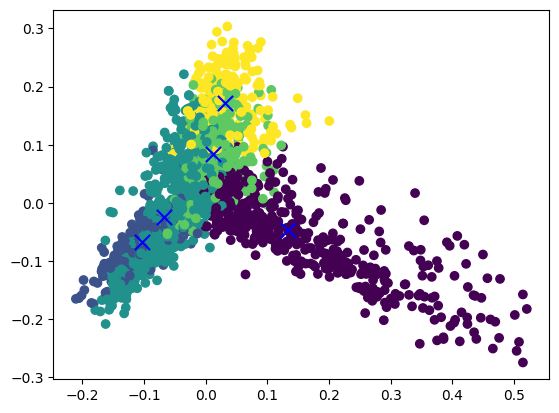

In [75]:
plt.scatter(reduced_feat[:,0], reduced_feat[:,1], c=pred)
plt.scatter(reduced_cen[:, 0], reduced_cen[:,1], marker='x', s=120, c='blue')
plt.show()

In [77]:
reduced_cen2 = pca.fit_transform(km2.cluster_centers_)
reduced_cen2

array([[-0.01454068,  0.18941084],
       [-0.09279914, -0.03857286],
       [ 0.00443593,  0.04168062],
       [ 0.24788694, -0.07361772],
       [-0.14498304, -0.11890089]])

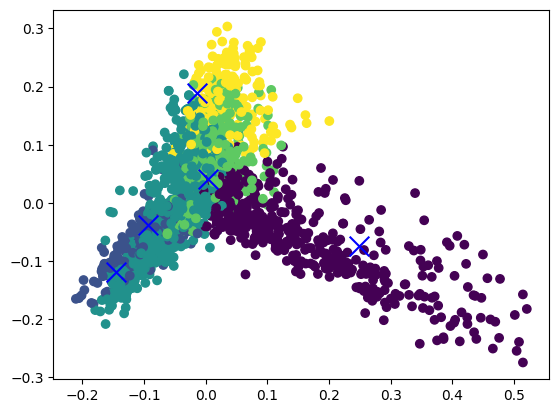

In [85]:
plt.scatter(reduced_feat[:,0], reduced_feat[:,1], c=pred)
plt.scatter(reduced_cen2[:, 0], reduced_cen2[:,1], marker='x', s=200, c="blue")
plt.show()